# Working with the fruit fly body model

Welcome to the fruit fly body model tutorial! This notebook will show you how to load a virtual fruit fly into the Mujoco physics simulator, fit its pose to keypoints captured from a real fly, control it using an artificial neural network, and record its behavior.

We'll start by importing a few modules, specifying a few interpreter options, and downloading the data we'll be using if we don't have it already:

In [ ]:
# Install dependencies.
!pip install h5py matplotlib mujoco==3.3.3 numpy onnx onnxruntime pillow rich scipy && \
git clone https://github.com/TuragaLab/flysim_tutorials.git /tmp/tutorial_repo && \
mv /tmp/tutorial_repo/body_tutorial/projectlib . && \
rm -rf /tmp/tutorial_repo && \
echo '{"file_format_version": "1.0.0", "ICD": {"library_path": "libEGL_nvidia.so.0"}}' \
     > /usr/share/glvnd/egl_vendor.d/10_nvidia.json

In [ ]:
# Import standard library modules.
import os
import pickle
import sys
from fnmatch import fnmatch
from glob import glob
from pathlib import Path
from scipy.spatial.transform import Rotation
from textwrap import wrap

# Tell Mujoco to use the "egl" renderer, which doesn't require a windowing system,
# if we're using Linux, and the default renderer otherwise.
os.environ["MUJOCO_GL"] = "egl" if sys.platform == "linux" else "glfw"

# Tell the interpreter to cache bytecode files in `_outbox/pycache/`.
sys.pycache_prefix = "_outbox/pycache/"

# Import third-party libraries.
import IPython.display
import matplotlib.pyplot as plt
import mujoco as mj
import numpy as np
import onnxruntime as ort
import rich.columns
import rich.console

# Import the project library.
import projectlib as pl

# Download data if we don't have it already.
pl.download_body_model_if_missing()
pl.download_pose_dataset_if_missing()
pl.download_controller_if_missing()

We encourage you to refer to the project library source code throughout this tutorial. Understanding the project library will be especially helpful if you decide to do a project involving the fruit fly body model and/or Mujoco.

Now that we've downloaded the data we need, let's list the files in the body model directory:

In [ ]:
rich.console.Console(force_jupyter=False, width=120).print(
    rich.columns.Columns(
        sorted(glob("**/*.*", root_dir="_inbox/flybody", recursive=True)),
        column_first=True,
        expand=True,
    )
)

abdomen_1_body.obj              coxa_T2_left_body.obj    rostrum_body.obj                tarsus_T2_4_left_body.obj 
abdomen_1_lower.obj             coxa_T2_right_body.obj   rostrum_bristle-brown.obj       tarsus_T2_4_right_body.obj
abdomen_2_body.obj              coxa_T3_left_body.obj    tarsal_claw_T1_left_brown.obj   tarsus_T3_1_left_body.obj 
abdomen_2_lower.obj             coxa_T3_right_body.obj   tarsal_claw_T1_right_brown.obj  tarsus_T3_1_right_body.obj
abdomen_3_body.obj              femur_T1_left_body.obj   tarsal_claw_T2_left_brown.obj   tarsus_T3_2_left_body.obj 
abdomen_3_lower.obj             femur_T1_right_body.obj  tarsal_claw_T2_right_brown.obj  tarsus_T3_2_right_body.obj
abdomen_4_body.obj              femur_T2_left_body.obj   tarsal_claw_T3_left_brown.obj   tarsus_T3_3_left_body.obj 
abdomen_4_lower.obj             femur_T2_right_body.obj  tarsal_claw_T3_right_brown.obj  tarsus_T3_3_right_body.obj
abdomen_5_body.obj              femur_T3_left_body.obj   tarsus_T1_1_left_body.obj       tarsus_T3_4_left_body.obj 
abdomen_5_lower.obj             femur_T3_right_body.obj  tarsus_T1_1_right_body.obj      tarsus_T3_4_right_body.obj
abdomen_6_body.obj              floor.xml                tarsus_T1_2_left_body.obj       thorax_black.obj          
abdomen_6_lower.obj             fruitfly.xml             tarsus_T1_2_right_body.obj      thorax_body.obj           
abdomen_7_body.obj              haltere_left_body.obj    tarsus_T1_3_left_body.obj       tibia_T1_left_body.obj    
abdomen_7_lower.obj             haltere_right_body.obj   tarsus_T1_3_right_body.obj      tibia_T1_right_body.obj   
abdomen_8_body.obj              haustellum_black.obj     tarsus_T1_4_left_body.obj       tibia_T2_left_body.obj    
antenna_left_black.obj          haustellum_body.obj      tarsus_T1_4_right_body.obj      tibia_T2_right_body.obj   
antenna_left_body.obj           head_black.obj           tarsus_T2_1_left_body.obj       tibia_T3_left_body.obj    
antenna_right_black.obj         head_body.obj            tarsus_T2_1_right_body.obj      tibia_T3_right_body.obj   
antenna_right_body.obj          head_ocelli.obj          tarsus_T2_2_left_body.obj       wing_left_brown.obj       
blender_model/drosophila.blend  head_red.obj             tarsus_T2_2_right_body.obj      wing_left_membrane.obj    
coxa_T1_left_body.obj           labrum_left_lower.obj    tarsus_T2_3_left_body.obj       wing_right_brown.obj      
coxa_T1_right_body.obj          labrum_right_lower.obj   tarsus_T2_3_right_body.obj      wing_right_membrane.obj

Here's an overview of what these files contain:

- `fruitfly.xml` is an [MJCF](https://mujoco.readthedocs.io/en/latest/modeling.html) specification of a [Mujoco](https://mujoco.readthedocs.io/en/stable/overview.html) model that contains the fruit fly as well as a few lights and cameras. (MJCF is Mujoco's XML model description format.) This file also specifies simulator settings, like the strength of gravity and the integration timestep, which we can override as needed.

- `floor.xml` is an MJCF file that [extends](https://mujoco.readthedocs.io/en/stable/XMLreference.html#include) `fruitfly.xml` by adding a well-polished checkered floor for the fly to stand and walk on.

- The `.obj` files describe body part meshes. They're referenced by `fruitfly.xml`, but we won't need to refer to them directly.

- `blender_model/drosophila.blend` is the [Blender](https://www.blender.org/) model that was used to generate `fruitfly.xml` and the mesh files.

It might be helpful to take a look at [`fruitfly.xml`](_inbox/flybody/fruitfly.xml) to get a rough sense of what a Mujoco model consists of. At a high level, a Mujoco model is a tree of bodies, either connected in some way or moving freely with respect to one another, annotated with additional information about how the simulator should operate on them (*e.g.* the integration timestep size), how custom user code can operate on them (*e.g.*, sensors and actuators), and how they should be rendered (*e.g.*, textures).

MJCF is very thoroughly documented, especially relative to the Mujoco Python API as a whole, and you can learn a lot about Mujoco by reading the MJCF specification. However, working with XML trees directly (*e.g.* using the standard library's [XML module](https://docs.python.org/3/library/xml.etree.elementtree.html#module-xml.etree.ElementTree)) can be a bit verbose, so it can be helpful to convert an MJCF document into a [model specification object](https://mujoco.readthedocs.io/en/stable/programming/modeledit.html)—a mutable data structure whose components correspond directly to MJCF elements—before inspecting or editing it.

Let's use `floor.xml` to construct a model specification object and list the body, joint, sensor, and actuator specifications it contains:

In [3]:
def _print_model_spec_components() -> None:
    model_spec = mj.MjSpec.from_file("_inbox/flybody/floor.xml")  # type: ignore

    body_names = " ".join(b.name for b in model_spec.bodies)
    joint_names = " ".join(j.name for j in model_spec.joints)
    sensor_names = " ".join(s.name for s in model_spec.sensors)
    actuator_names = " ".join(a.name for a in model_spec.actuators)

    print(f"Bodies ({len(model_spec.bodies)}):")
    print("  " + "\n  ".join(wrap(body_names, width=120)))
    print(f"\nJoints ({len(model_spec.joints)}):")
    print("  " + "\n  ".join(wrap(joint_names, width=120)))
    print(f"\nSensors ({len(model_spec.sensors)}):")
    print("  " + "\n  ".join(wrap(sensor_names, width=120)))
    print(f"\nActuators ({len(model_spec.actuators)}):")
    print("  " + "\n  ".join(wrap(actuator_names, width=120)))

_print_model_spec_components()

Bodies (68):
  world thorax head wing_left wing_right abdomen haltere_left haltere_right coxa_T1_left coxa_T1_right coxa_T2_left
  coxa_T2_right coxa_T3_left coxa_T3_right rostrum antenna_left antenna_right haustellum labrum_left labrum_right
  abdomen_2 abdomen_3 abdomen_4 abdomen_5 abdomen_6 abdomen_7 femur_T1_left tibia_T1_left tarsus_T1_left tarsus2_T1_left
  tarsus3_T1_left tarsus4_T1_left claw_T1_left femur_T1_right tibia_T1_right tarsus_T1_right tarsus2_T1_right
  tarsus3_T1_right tarsus4_T1_right claw_T1_right femur_T2_left tibia_T2_left tarsus_T2_left tarsus2_T2_left
  tarsus3_T2_left tarsus4_T2_left claw_T2_left femur_T2_right tibia_T2_right tarsus_T2_right tarsus2_T2_right
  tarsus3_T2_right tarsus4_T2_right claw_T2_right femur_T3_left tibia_T3_left tarsus_T3_left tarsus2_T3_left
  tarsus3_T3_left tarsus4_T3_left claw_T3_left femur_T3_right tibia_T3_right tarsus_T3_right tarsus2_T3_right
  tarsus3_T3_right tarsus4_T3_right claw_T3_right

Joints (103):
  free head_abduct head

If you aren't familiar with some of these anatomical terms, this might be a good time to look them up. You don't need to have encyclopedic knowledge of insect anatomy to use the fruit fly body model, but it can be helpful to look at a labeled diagram or two from time to time.

Now let's compile our model specification to create a model object, which represents our scene in a format that Mujoco can interface with efficiently, and run a simulation to see the fly shift from its initial pose to its resting pose (both of these poses are functions of the model specification; see the documentation for the [`stiffness`](https://mujoco.readthedocs.io/en/stable/XMLreference.html#body-joint-stiffness) and [`springref`](http://mujoco.readthedocs.io/en/stable/XMLreference.html#body-joint-springref) joint properties for more information):

In [4]:
def _render_resting_fly_video(output_path: str) -> None:
    model_spec = mj.MjSpec.from_file("_inbox/flybody/floor.xml")  # type: ignore
    model = model_spec.compile()

    sim_state = mj.MjData(model)  # type: ignore
    video_writer = pl.VideoWriter(output_path, duration=0.125, play_speed=0.025)

    while video_writer.is_writing():
        mj.mj_step(model, sim_state)  # type: ignore
        video_writer.send(sim_state.time, lambda: pl.render(model, sim_state, "track1"))

_render_resting_fly_video("_outbox/vis-01.mp4")
IPython.display.Video("_outbox/vis-01.mp4", embed=True)

Generating frames... (125/125)
Encoding video...


`mj.mj_step` advances the simulation state one timestep, the duration of which is stored in `model.opt.timestep`.

## Taking measurements

A video can provide a holistic overview of what's happening in a simulation, but sometimes we want a bit more precision. Let's plot the left wing joint angles as a function of time over the first 250ms of the same simulation:

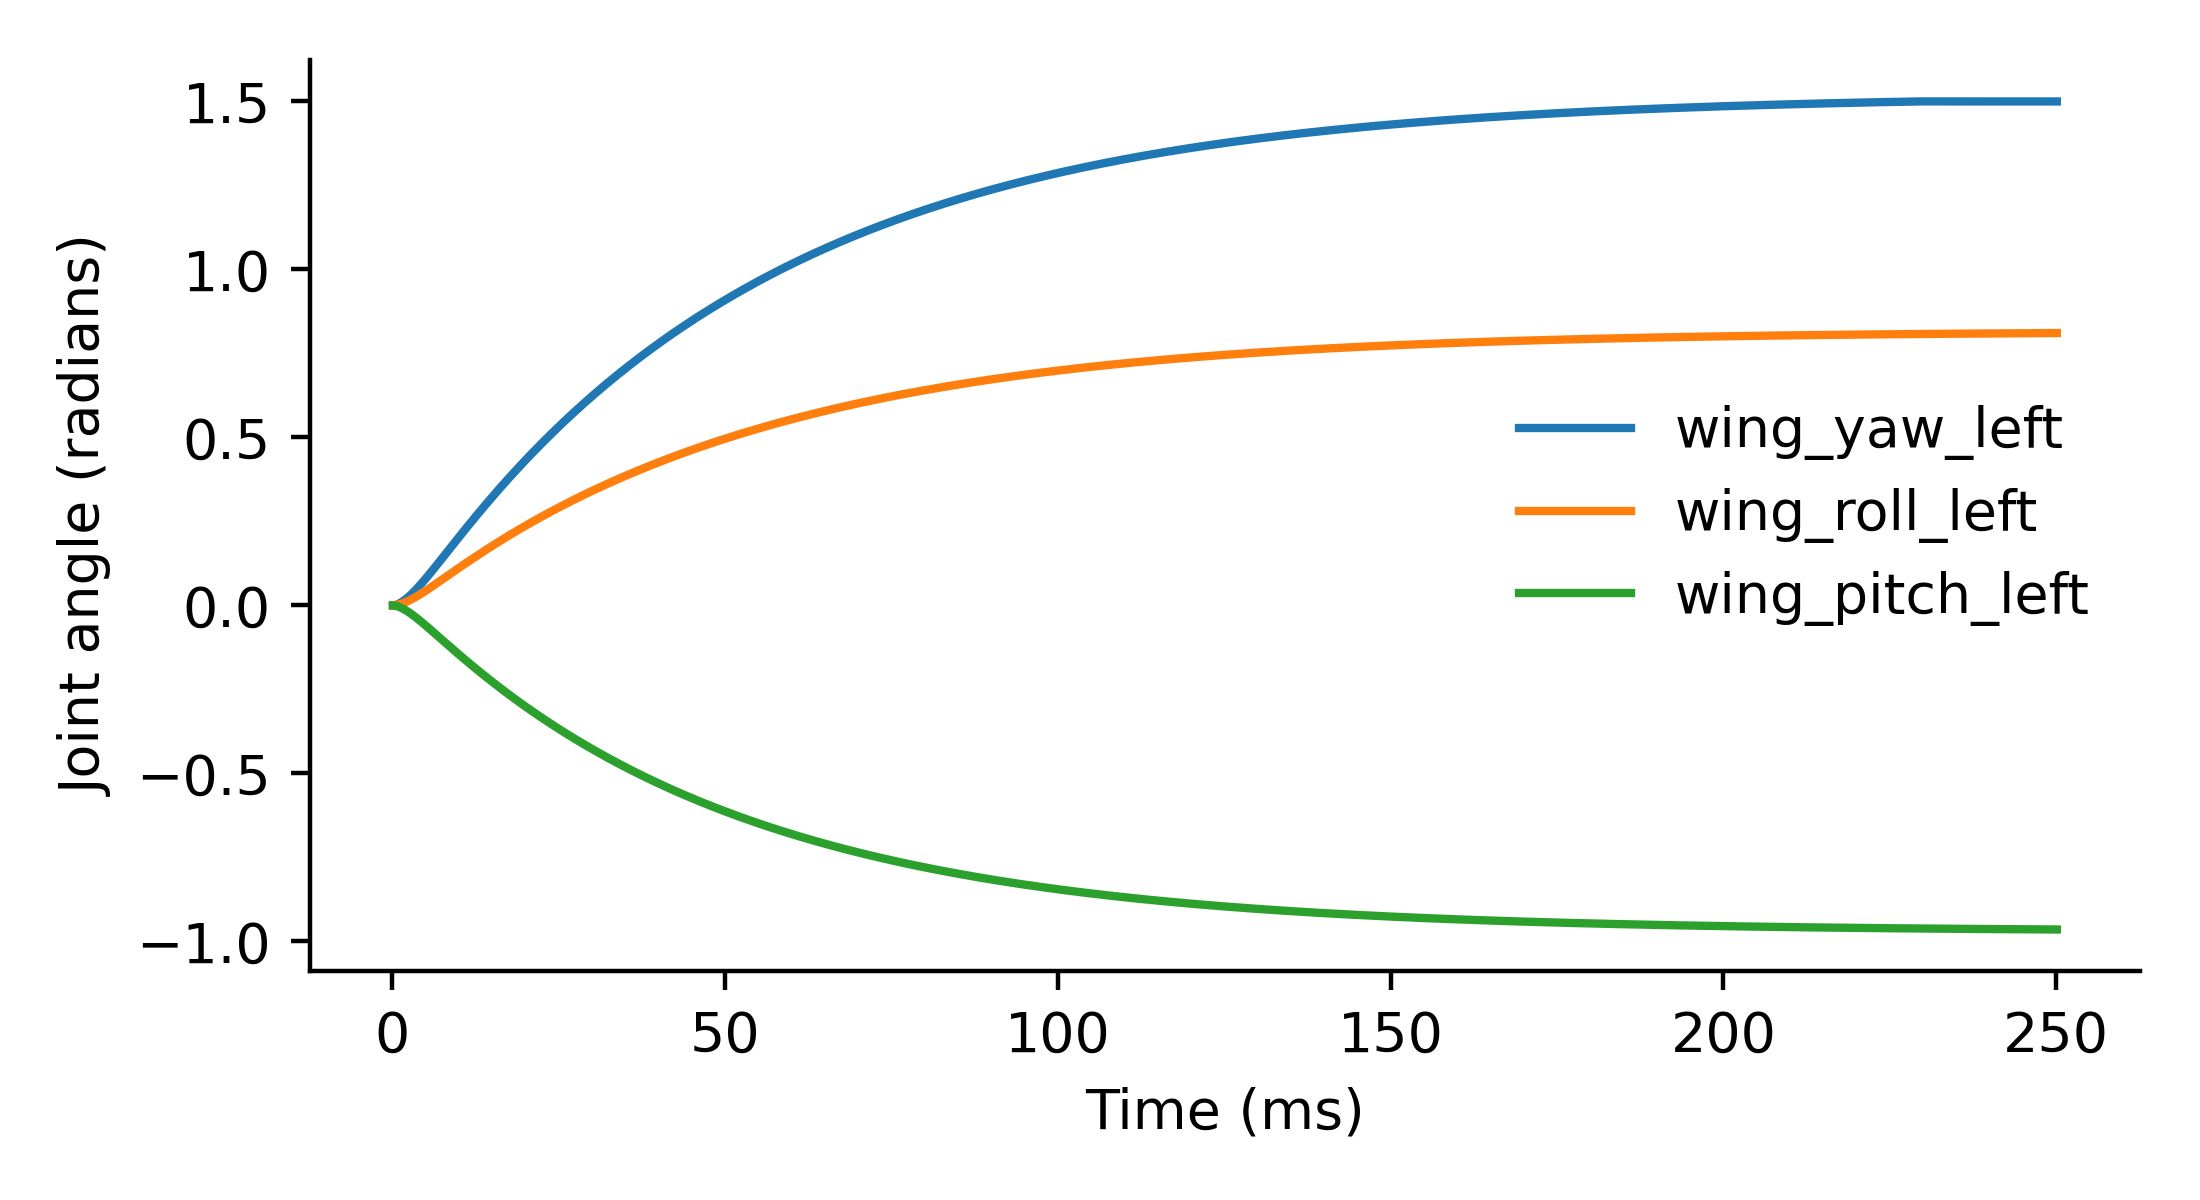

In [5]:
def _vis_left_wing_pose_trajectory(output_path: str) -> None:
    model_spec = mj.MjSpec.from_file("_inbox/flybody/floor.xml")  # type: ignore
    model = model_spec.compile()
    joint_names = [j.name for j in model_spec.joints if fnmatch(j.name, "wing_*_left")]

    sim_state = mj.MjData(model)  # type: ignore
    timestamps = list[float]()
    joint_angles = {name: list[float]() for name in joint_names}

    while sim_state.time < 0.25:
        mj.mj_step(model, sim_state)  # type: ignore
        timestamps.append(1000.0 * sim_state.time)
        for name in joint_names:
            joint_angles[name].append(sim_state.joint(name).qpos[0])

    plt.figure(figsize=(5.5, 3.0), dpi=400.0)
    plt.xlabel("Time (ms)")
    plt.ylabel("Joint angle (radians)")
    for name in joint_names:
        plt.plot(timestamps, joint_angles[name], label=name)
    plt.legend(frameon=False)
    plt.gca().spines[["top", "right"]].set_visible(False)
    plt.tight_layout()

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    plt.savefig(output_path)
    plt.close()

_vis_left_wing_pose_trajectory("_outbox/vis-02.png")
IPython.display.Image("_outbox/vis-02.png", width=640)

Mujoco uses `qpos` as a shorthand for "position in joint pose space" throughout its API. It also uses `qvel`, `xpos`, and `xvel` as shorthand for "velocity in joint pose space", "position in world Cartesian coordinates", and "velocity in world Cartesian coordinates", respectively.

Let's now rerun the simulation, plotting the location of the fly's center of mass. It turns out that we won't need to use a specification object for this next cell, so we can go straight from the MJCF file to the model by calling `mj.MjModel.from_xml_path`:

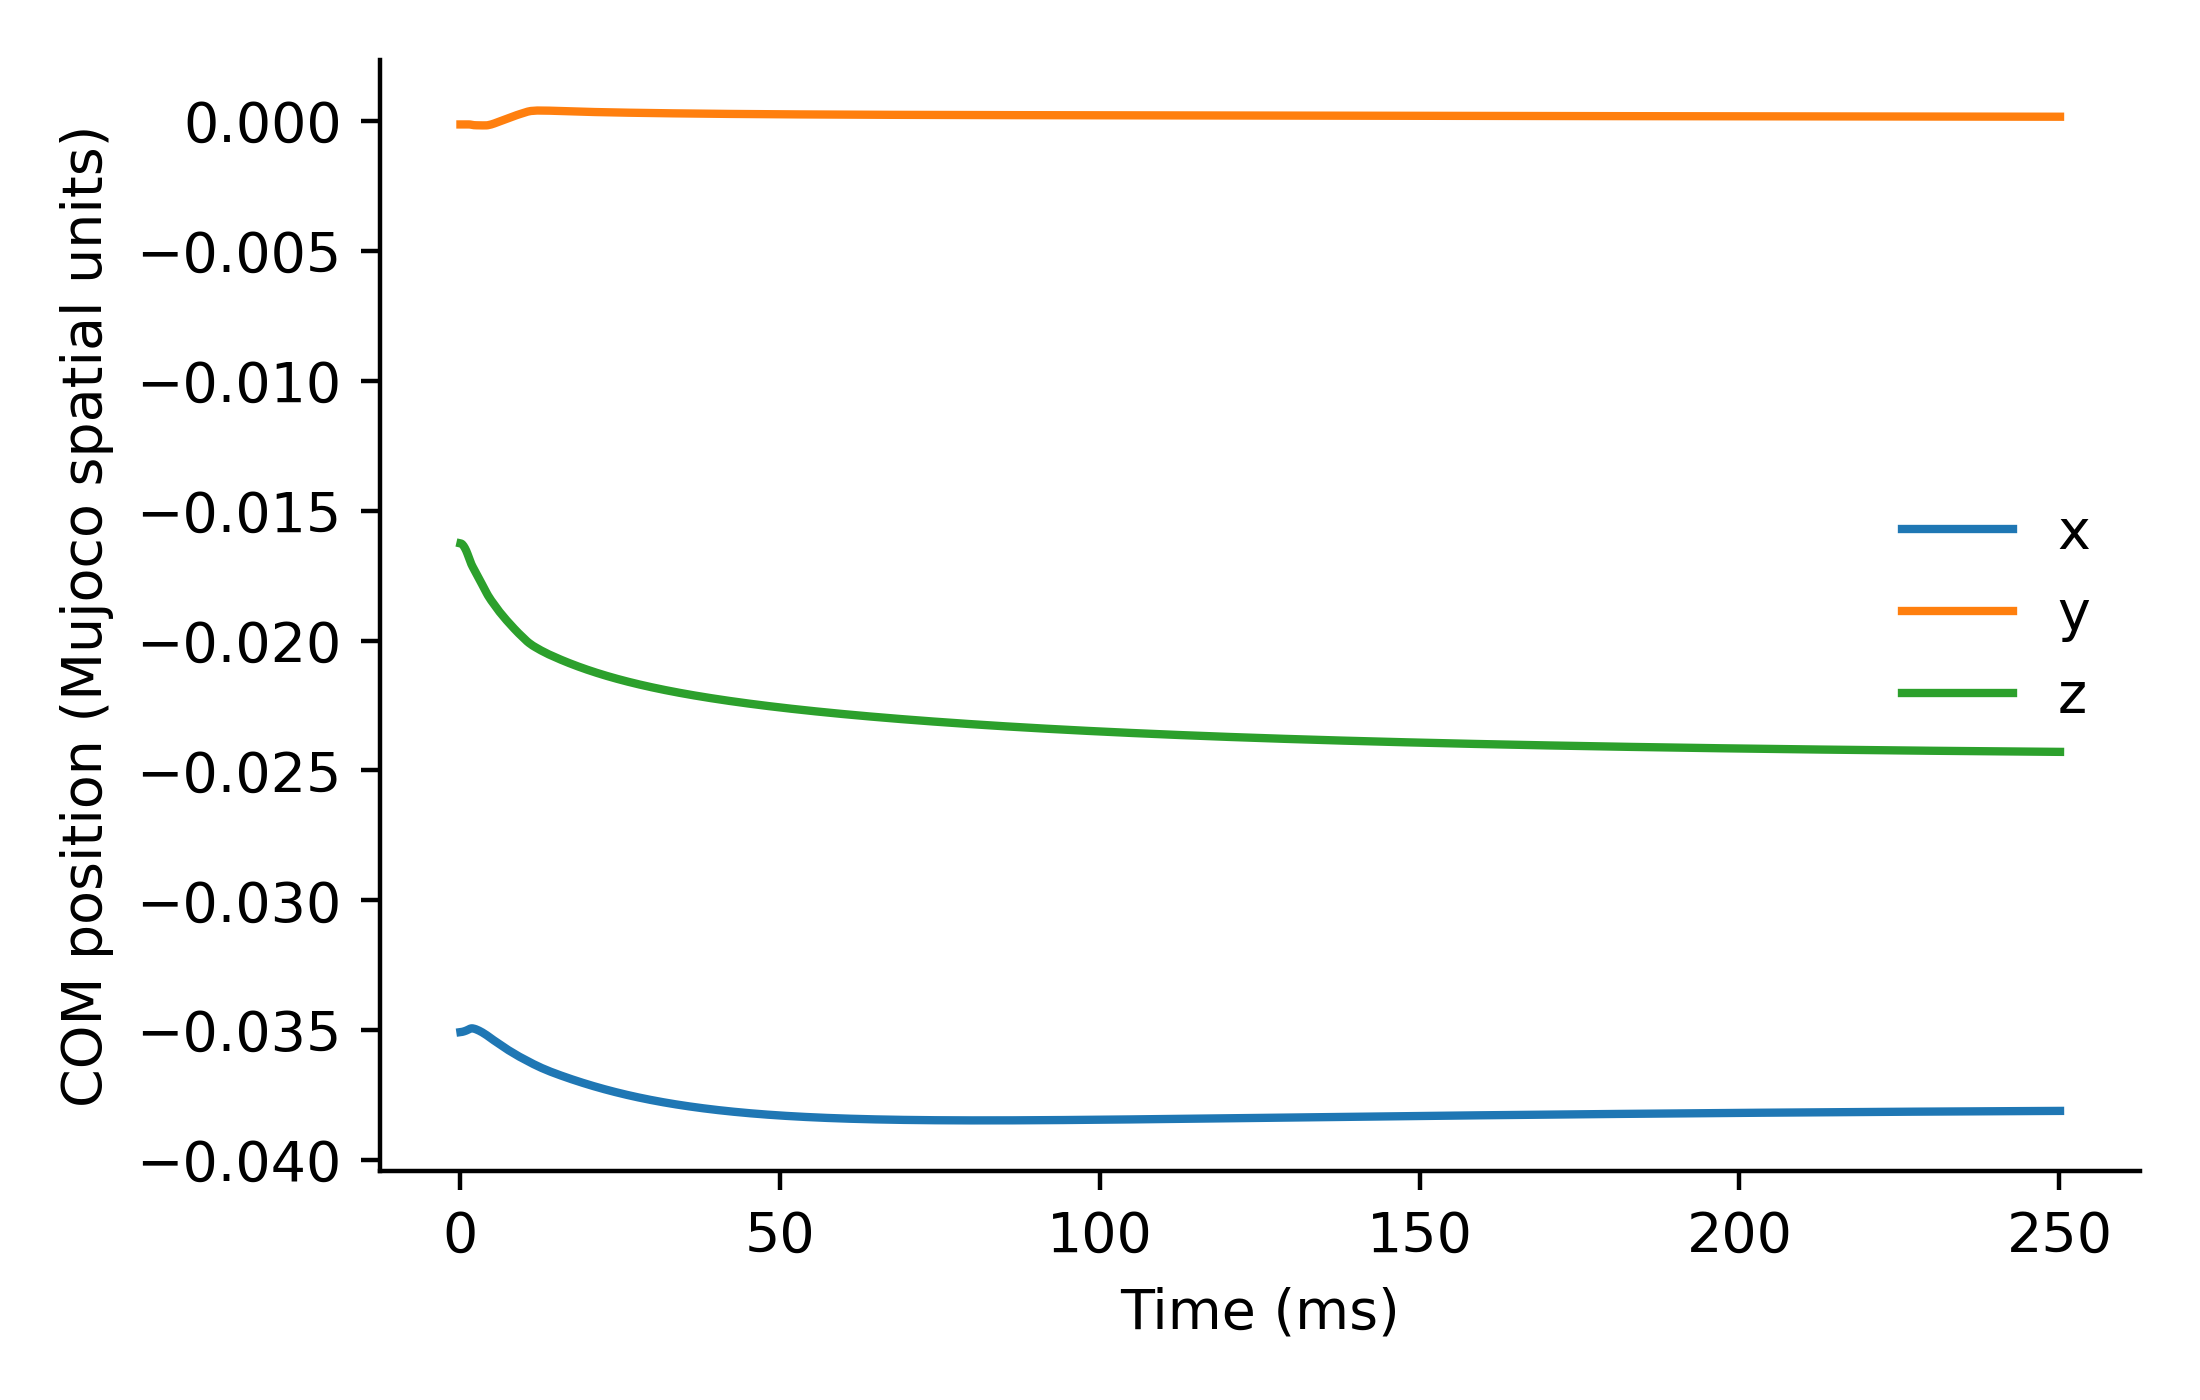

In [ ]:
def _vis_center_of_mass_trajectory(output_path: str) -> None:
    model = mj.MjModel.from_xml_path("_inbox/flybody/floor.xml")  # type: ignore
    sim_state = mj.MjData(model)  # type: ignore
    timestamps = list[float]()
    positions = {coord_name: list[float]() for coord_name in "xyz"}

    while sim_state.time < 0.25:
        mj.mj_step(model, sim_state)  # type: ignore
        timestamps.append(1000.0 * sim_state.time)
        com = sim_state.body("thorax").subtree_com
        positions["x"].append(com[0])
        positions["y"].append(com[1])
        positions["z"].append(com[2])

    plt.figure(figsize=(5.5, 3.5), dpi=400.0)
    plt.xlabel("Time (ms)")
    plt.ylabel("COM position (Mujoco spatial units)")
    for coord_name in "xyz":
        plt.plot(timestamps, positions[coord_name], label=coord_name)
    plt.legend(frameon=False)
    plt.gca().spines[["top", "right"]].set_visible(False)
    plt.tight_layout()
    
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    plt.savefig(output_path)
    plt.close()

_vis_center_of_mass_trajectory("_outbox/vis-03.png")
IPython.display.Image("_outbox/vis-03.png", width=640)

And let's also plot the pressure measured by the fly's [tarsal](https://neuromechfly.org/_images/fly_anatomy.jpg) sensors at the very beginning of the simulation, as the fly settles onto the floor:

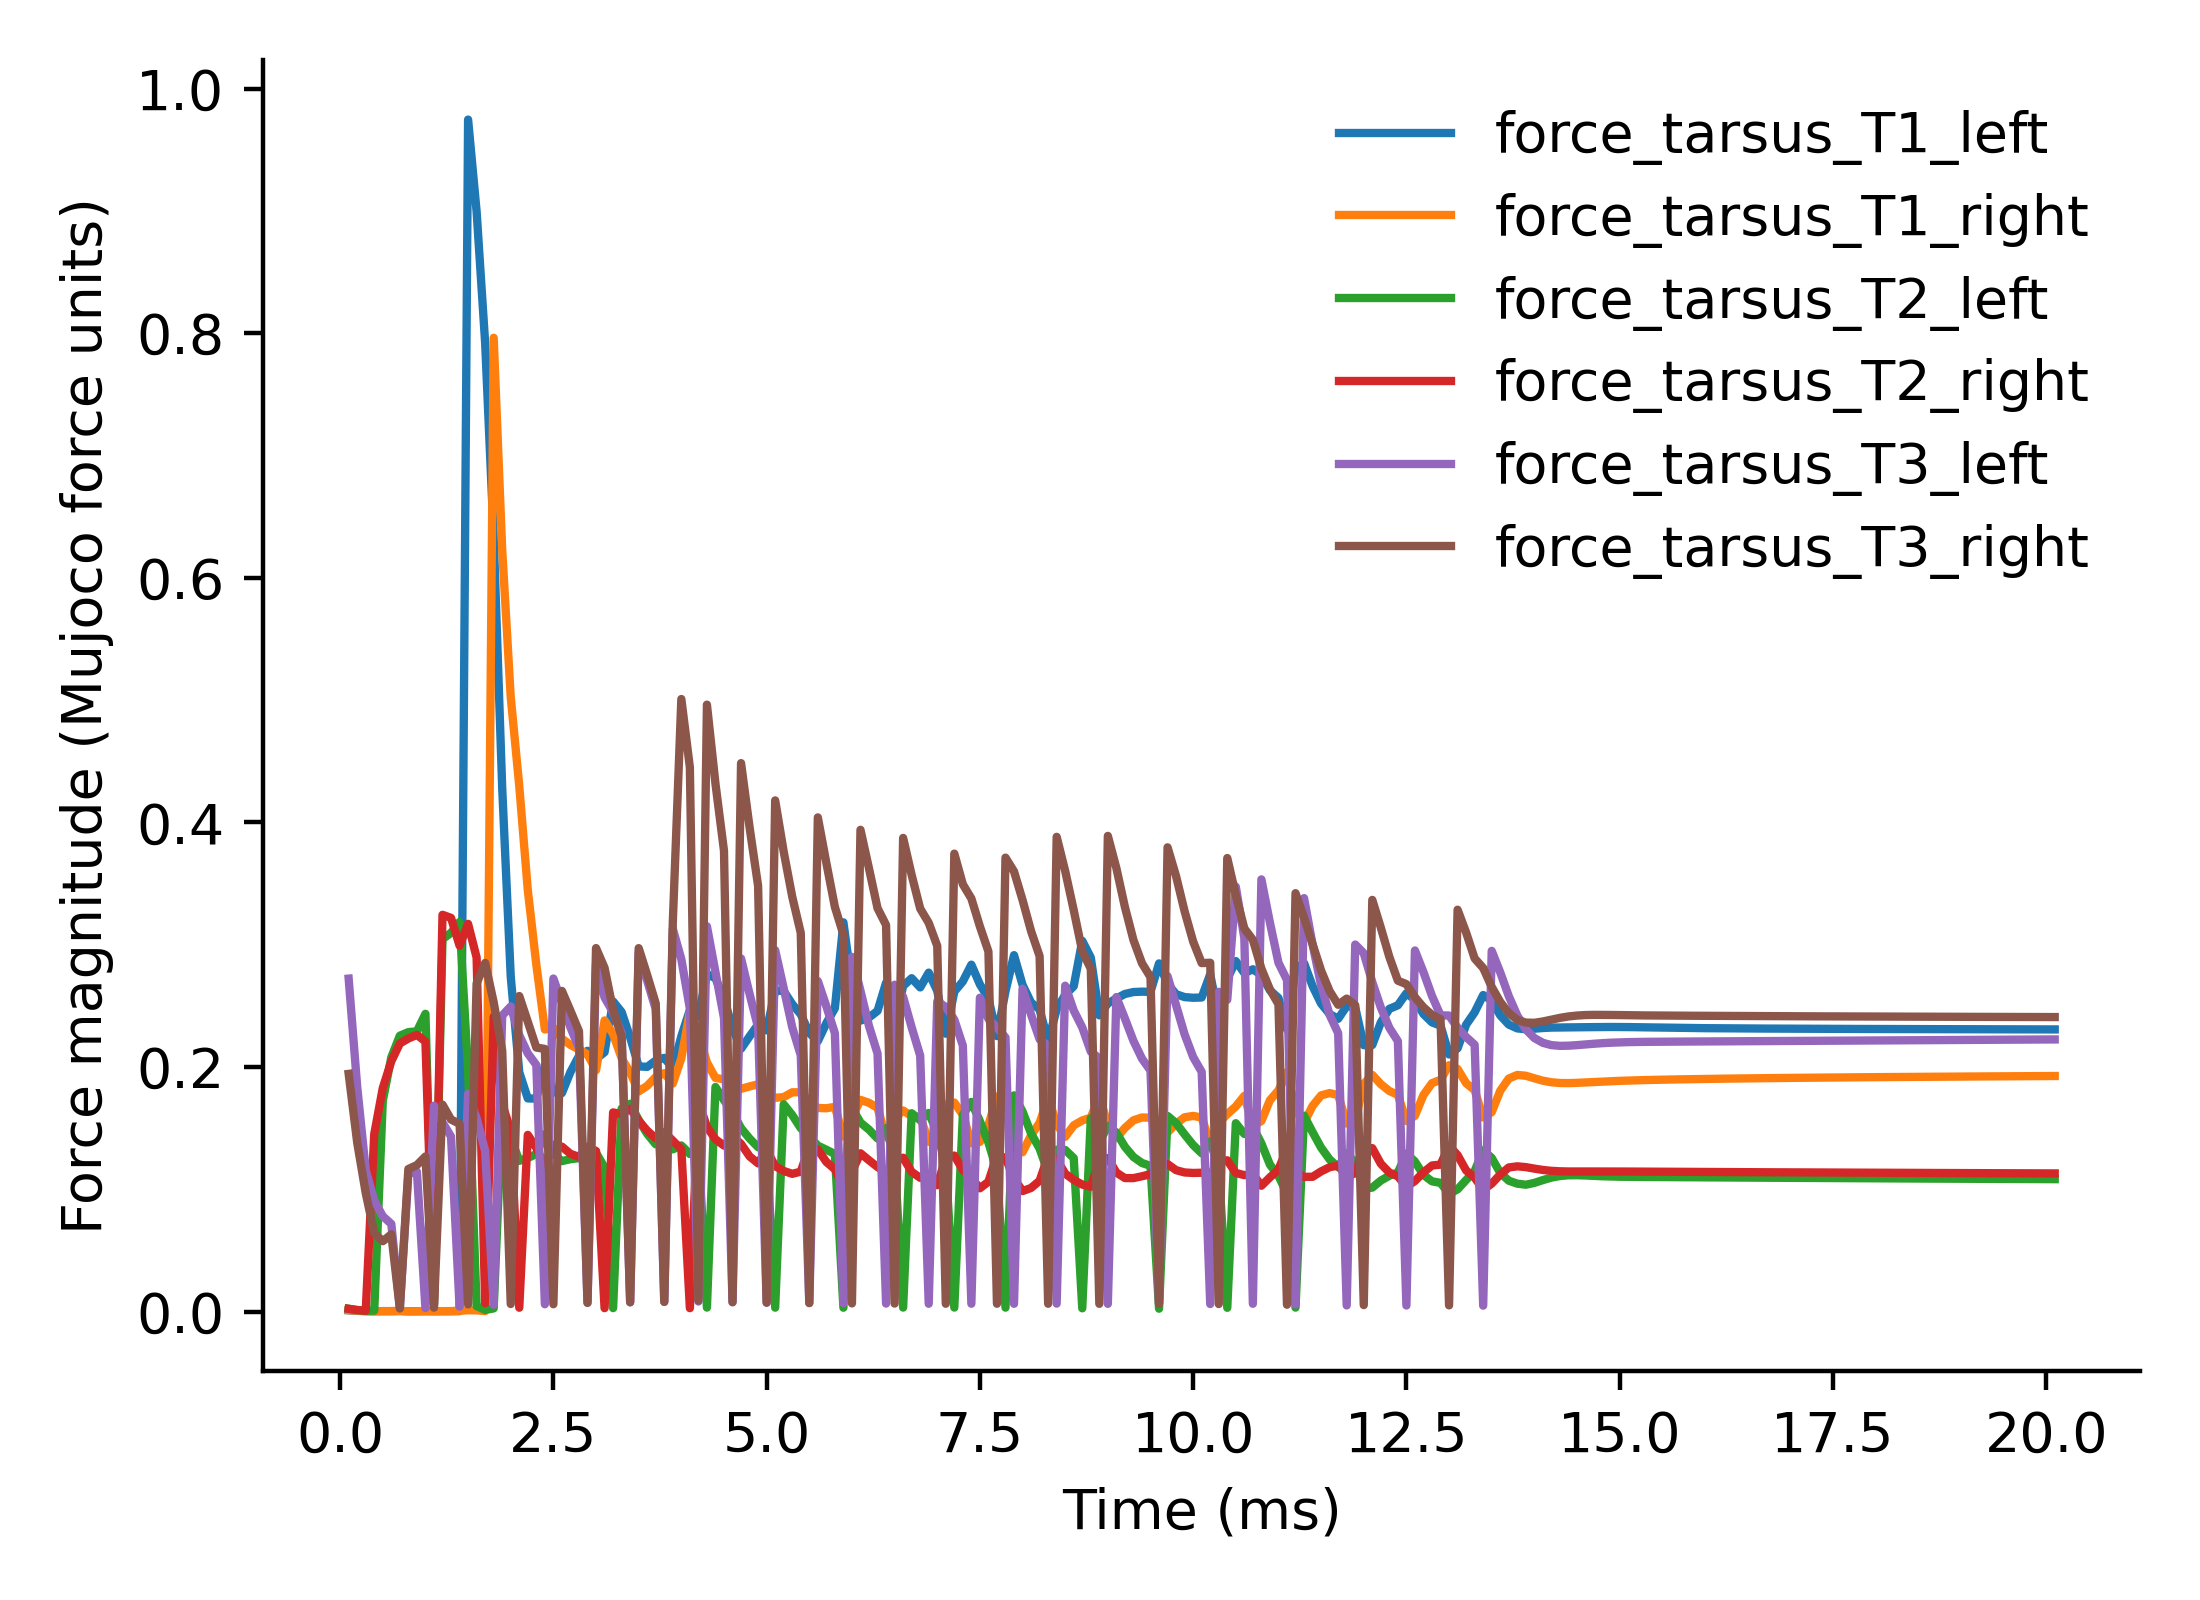

In [7]:
def _vis_force_measurements(output_path: str) -> None:
    model_spec = mj.MjSpec.from_file("_inbox/flybody/floor.xml")  # type: ignore
    model = model_spec.compile()
    force_sensor_code = mj.mjtSensor.mjSENS_FORCE  # type: ignore
    sensor_names = [s.name for s in model_spec.sensors if s.type == force_sensor_code]

    sim_state = mj.MjData(model)  # type: ignore
    timestamps = list[float]()
    force_measurements = {name: list[float]() for name in sensor_names}

    while sim_state.time < 0.02:
        mj.mj_step(model, sim_state)  # type: ignore
        timestamps.append(1000.0 * sim_state.time)
        for name in sensor_names:
            sensor = sim_state.sensor(name)
            measurement = float(np.linalg.norm(sensor.data))
            force_measurements[name].append(measurement)

    plt.figure(figsize=(5.5, 4.0), dpi=400.0)
    plt.xlabel("Time (ms)")
    plt.ylabel("Force magnitude (Mujoco force units)")
    for name in force_measurements:
        plt.plot(timestamps, force_measurements[name], label=name)
    plt.legend(frameon=False)
    plt.gca().spines[["top", "right"]].set_visible(False)
    plt.tight_layout()

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    plt.savefig(output_path)
    plt.close()

_vis_force_measurements("_outbox/vis-04.png")
IPython.display.Image("_outbox/vis-04.png", width=640)

This might be a good time to stop and think about what else we can measure from the body model over the course of a simulation, especially in the context of comparing the model to real flies.

## Stretching our limbs

Let's try sending control signals to a few of the fly's actuators:

In [8]:
def _vis_limb_actuation(output_path: str) -> None:
    model = mj.MjModel.from_xml_path("_inbox/flybody/floor.xml")  # type: ignore
    actuator_names = ["femur_T1_left", "tibia_T2_right", "tarsus_T3_left"]
    
    sim_state = mj.MjData(model)  # type: ignore
    video_writer = pl.VideoWriter(output_path, duration=0.20, play_speed=0.025)

    while video_writer.is_writing():
        for i, actuator_name in enumerate(actuator_names):
            duration_active = video_writer.duration / (len(actuator_names) + 1)
            active_period_beg = i * duration_active
            active_period_end = (i + 1) * duration_active
            active = active_period_beg <= sim_state.time < active_period_end
            sim_state.actuator(actuator_name).ctrl[0] = 0.5 if active else 0.0

        mj.mj_step(model, sim_state)  # type: ignore
        video_writer.send(sim_state.time, lambda: pl.render(model, sim_state, "track1"))

_vis_limb_actuation("_outbox/vis-05.mp4")
IPython.display.Video("_outbox/vis-05.mp4", embed=True)

Generating frames... (200/200)
Encoding video...


An actuator will continue applying force until it receives a control signal of zero. However, joints can only move so far. Let's inspect the range of motion of each of the fly's leg joints:

In [9]:
def _print_motion_ranges() -> None:
    model_spec = mj.MjSpec.from_file("_inbox/flybody/fruitfly.xml")  # type: ignore
    leg_joints = [
        j for j in model_spec.joints
        if ("tarsus" in j.name or "tibia" in j.name or "femur" in j.name)
    ]

    for joint in leg_joints:
        print(f"`{joint.name}.qpos[0]` will always be in the range {joint.range}.")

_print_motion_ranges()

`femur_twist_T1_left.qpos[0]` will always be in the range [-1.  1.].
`femur_T1_left.qpos[0]` will always be in the range [-0.15  2.  ].
`tibia_T1_left.qpos[0]` will always be in the range [-1.35  1.3 ].
`tarsus_T1_left.qpos[0]` will always be in the range [-0.7  1.2].
`tarsus2_T1_left.qpos[0]` will always be in the range [-0.36  0.36].
`tarsus3_T1_left.qpos[0]` will always be in the range [-0.36  0.36].
`tarsus4_T1_left.qpos[0]` will always be in the range [-0.36  0.36].
`tarsus5_T1_left.qpos[0]` will always be in the range [-0.36  0.36].
`femur_twist_T1_right.qpos[0]` will always be in the range [-1.  1.].
`femur_T1_right.qpos[0]` will always be in the range [-0.15  2.  ].
`tibia_T1_right.qpos[0]` will always be in the range [-1.35  1.3 ].
`tarsus_T1_right.qpos[0]` will always be in the range [-0.7  1.2].
`tarsus2_T1_right.qpos[0]` will always be in the range [-0.36  0.36].
`tarsus3_T1_right.qpos[0]` will always be in the range [-0.36  0.36].
`tarsus4_T1_right.qpos[0]` will always be 

The way control signals are translated into forces depends on the actuator. For example, the control signals for the fly's limb joint actuators are position set points, while the control signals for the fly's adhesion actuators are target force outputs. See the [actuation model section](https://mujoco.readthedocs.io/en/stable/computation/index.html#actuation-model) of the Mujoco documentation and the [actuator element section](https://mujoco.readthedocs.io/en/stable/XMLreference.html#actuator) of the MJCF documentation for more details.

## Striking a pose

Next, let's try to position the fly's joints to match the locations of tracking keypoints captured from a real fly while it was grooming itself. Grooming behavior involves articulating the fly's joints into a wide variety of poses, so it's a good setting in which to compare our model to actual flies. We'll try to match the captured pose using iterative optimization:

In [10]:
def _vis_inverse_kinematics(output_path: str) -> None:
    pose_dataset = pickle.loads(Path("_inbox/fly-grooming-poses.pkl").read_bytes())
    target_positions = pose_dataset["poses"][120]

    spec = mj.MjSpec.from_file("_inbox/flybody/floor.xml")  # type: ignore
    pl.add_keypoint_sites(spec)
    pl.add_target_position_sites(spec, target_positions)

    model = spec.compile()
    optimizer = pl.PoseOptimizer(
        model=model,
        sim_state=mj.MjData(model),  # type: ignore
        joint_names=[j.name for j in spec.body("thorax").find_all("joint")],
        site_names=[f"site_{i}" for i in range(36)],
        target_pos=target_positions,
        reg_coef=0.0001,
    )

    video_writer = pl.VideoWriter(output_path, duration=1.0001, play_speed=0.1)

    for i, t in enumerate(np.linspace(0, 1.0, 10_001)):
        learning_rate = 0.001 * float(0.5 + 0.5 * np.cos(np.pi * t))
        optimizer.step(learning_rate, momentum_coef=0.9)

        camera = optimizer.sim_state.camera("track1")  # type: ignore
        orig_angle = np.arctan2(*camera.xpos[:2])  # type: ignore
        rotation = 4.0 * np.pi * max(float(t) - 0.5, 0.0)
        new_angle = orig_angle + rotation
        distance = np.linalg.norm(camera.xpos[:2])  # type: ignore
        rot_mat = Rotation.from_euler("z", rotation).as_matrix()
        camera.xpos[0] = distance * np.cos(new_angle)  # type: ignore
        camera.xpos[1] = distance * np.sin(new_angle)  # type: ignore
        camera.xmat = (rot_mat @ camera.xmat.reshape(3, 3)).flatten()  # type: ignore

        video_writer.send(
            timestamp=float(t),
            render_fn=(lambda: pl.caption(
                pl.render(model, optimizer.sim_state, "track1", 480, 640),
                f"Iteration {i:05d}, loss={optimizer.loss():0.6f}",
            )),
        )

_vis_inverse_kinematics("_outbox/vis-06.mp4")
IPython.display.Video("_outbox/vis-06.mp4", embed=True)

Generating frames... (251/251)
Encoding video...


## Walking the walk

Now let's simulate walking using a learned controller. Every 0.002 seconds, this controller generates control signals for the fly's actuators, as a function of (1) observations about the fly's state and (2) a target trajectory. (See https://doi.org/10.1038/s41586-025-09029-4 for more information.) We'll start by instructing the fly to walk in a straight line:

In [11]:
def _vis_walking(output_path: str) -> None:
    model_spec = mj.MjSpec.from_file("_inbox/flybody/floor.xml")  # type: ignore
    pl.remove_actuators(model_spec, "antenna*|wing*|rostrum*|haustellum*|*labrum*")
    pl.add_actuator_filtering(model_spec)

    model = model_spec.compile()
    act_ind = pl.get_walking_actuator_indices(model)
    sensor_suite = pl.SensorSuite(model)

    sim_state = mj.MjData(model)  # type: ignore
    ort_session = ort.InferenceSession("_inbox/controller.onnx")
    video_writer = pl.VideoWriter(output_path, duration=1.0, play_speed=0.125)

    while video_writer.is_writing():
        for _ in range(20):
            mj.mj_step(model, sim_state)  # type: ignore
            sensor_suite.update_state(sim_state)

        sensor_readings = sensor_suite.read()
        target_traj = pl.encode_trajectory(lambda t: (2.0 * t, 0.0, 0.0))
        controller_input = [pl.pack_controller_inputs(sensor_readings, target_traj)]
        controller_outputs = ort_session.run(["control_signal_means"], {"input": controller_input})
        sim_state.ctrl[act_ind] = pl.to_control_range(model, act_ind, controller_outputs[0])  # type: ignore

        video_writer.send(sim_state.time, lambda: pl.render(model, sim_state, "track1"))

_vis_walking("_outbox/vis-07.mp4")
IPython.display.Video("_outbox/vis-07.mp4", embed=True)

Generating frames... (200/200)
Encoding video...


Note that to use the controller effectively, we need make a couple small tweaks to the model spec, in order to match the conditions in which the controller was trained. Also, the controller generates a Gaussian distribution over actuator inputs, which is helpful during training, but since we aren't training the controller right now, we just use the mode of this distribution (`"control_signal_means"`).

In addition to walking in a straight line, we can also make the fly turn. Let's send the controller a target trajectory that follows the circumference of a circle:

In [12]:
def _vis_turning(output_path: str) -> None:
    model_spec = mj.MjSpec.from_file("_inbox/flybody/floor.xml")  # type: ignore
    pl.remove_actuators(model_spec, "antenna*|wing*|rostrum*|haustellum*|*labrum*")
    pl.add_actuator_filtering(model_spec)

    model = model_spec.compile()
    act_ind = pl.get_walking_actuator_indices(model)
    sensor_suite = pl.SensorSuite(model)

    sim_state = mj.MjData(model)  # type: ignore
    ort_session = ort.InferenceSession("_inbox/controller.onnx")
    video_writer = pl.VideoWriter(output_path, duration=1.0, play_speed=0.125)

    tr = 3.0  # Trajectory radius
    tv = 0.6  # Tangential velocity, in radians/second
    pos_fn = lambda t: (tr * np.sin(tv * t), tr * (1.0 - np.cos(tv * t)), 0.0)
    ori_fn = lambda t: (np.cos(tv * t / 2.0), 0.0, 0.0, np.sin(tv * t / 2.0))

    while video_writer.is_writing():
        for _ in range(20):
            mj.mj_step(model, sim_state)  # type: ignore
            sensor_suite.update_state(sim_state)

        sensor_readings = sensor_suite.read()
        target_traj = pl.encode_trajectory(pos_fn, ori_fn)
        controller_input = [pl.pack_controller_inputs(sensor_readings, target_traj)]
        controller_outputs = ort_session.run(["control_signal_means"], {"input": controller_input})
        sim_state.ctrl[act_ind] = pl.to_control_range(model, act_ind, controller_outputs[0])  # type: ignore

        video_writer.send(sim_state.time, lambda: pl.render(model, sim_state, "track1"))

_vis_turning("_outbox/vis-08.mp4")
IPython.display.Video("_outbox/vis-08.mp4", embed=True)

Generating frames... (200/200)
Encoding video...


## Inclement weather

Now let's try using the walking controller in a situation it wasn't trained to handle—obstacles falling from the sky:

In [13]:
def _vis_walking_with_falling_spheres(output_path: str) -> None:
    n_spheres = 300
    drop_height = 0.35

    model_spec = mj.MjSpec.from_file("_inbox/flybody/floor.xml")  # type: ignore
    pl.remove_actuators(model_spec, "antenna*|wing*|rostrum*|haustellum*|*labrum*")
    pl.add_actuator_filtering(model_spec)

    for i in range(n_spheres):
        sphere = model_spec.worldbody.add_body(
            pos=(4.0 * np.random.rand(), -0.5 + 1.0 * np.random.rand(), drop_height),
        )
        sphere.add_geom(
            type=mj.mjtGeom.mjGEOM_SPHERE,  # type: ignore
            size=(0.03, 0.0, 0.0),
            mass=1e-4,
            rgba=(*np.random.rand(3), 1.0),
        )
        sphere.add_joint(
            name=f"sphere_free_joint_{i}",
            type=mj.mjtJoint.mjJNT_FREE,  # type: ignore
        )

    model = model_spec.compile()
    sphere_drop_times = np.random.rand(n_spheres)
    act_ind = pl.get_walking_actuator_indices(model)
    sensor_suite = pl.SensorSuite(model)

    sim_state = mj.MjData(model)  # type: ignore
    ort_session = ort.InferenceSession("_inbox/controller.onnx")
    video_writer = pl.VideoWriter(output_path, duration=1.0, play_speed=0.125)

    while video_writer.is_writing():
        for i in range(n_spheres):
            joint = sim_state.joint(f"sphere_free_joint_{i}")
            if sim_state.time < sphere_drop_times[i]:
                joint.qpos[2] = drop_height
                joint.qvel[0] = 0.75 * np.random.randn()
                joint.qvel[1] = 0.75 * np.random.randn()
                joint.qvel[2] = 0.0

        for _ in range(20):
            mj.mj_step(model, sim_state)  # type: ignore
            sensor_suite.update_state(sim_state)

        sensor_readings = sensor_suite.read()
        target_traj = pl.encode_trajectory(lambda t: (2.0 * t, 0.0, 0.0))
        controller_input = [pl.pack_controller_inputs(sensor_readings, target_traj)]
        controller_outputs = ort_session.run(["control_signal_means"], {"input": controller_input})
        sim_state.ctrl[act_ind] = pl.to_control_range(model, act_ind, controller_outputs[0])  # type: ignore

        video_writer.send(sim_state.time, lambda: pl.render(model, sim_state, "track1"))

_vis_walking_with_falling_spheres("_outbox/vis-09.mp4")
IPython.display.Video("_outbox/vis-09.mp4", embed=True)

Generating frames... (200/200)
Encoding video...


## Control network electrophysiology

Now that our fly is walking, let's take a closer look at the controller. Take a minute to download the control network (`_inbox/controller.onnx`), open it in the [Netron](https://netron.app/) viewer, and look over its structure. A few questions to ask:

- What are the network's inputs?
- What are the network's outputs?
- Aside from the structure and the parameters, is the network stateless or does it maintain a dynamic internal state?
- Which internal signals are guaranteed to be within a bounded range?
- How many parameters does it have?

Now that we're more familiar with the controller, let's visualize some of the internal signals it generates as the fly walks:

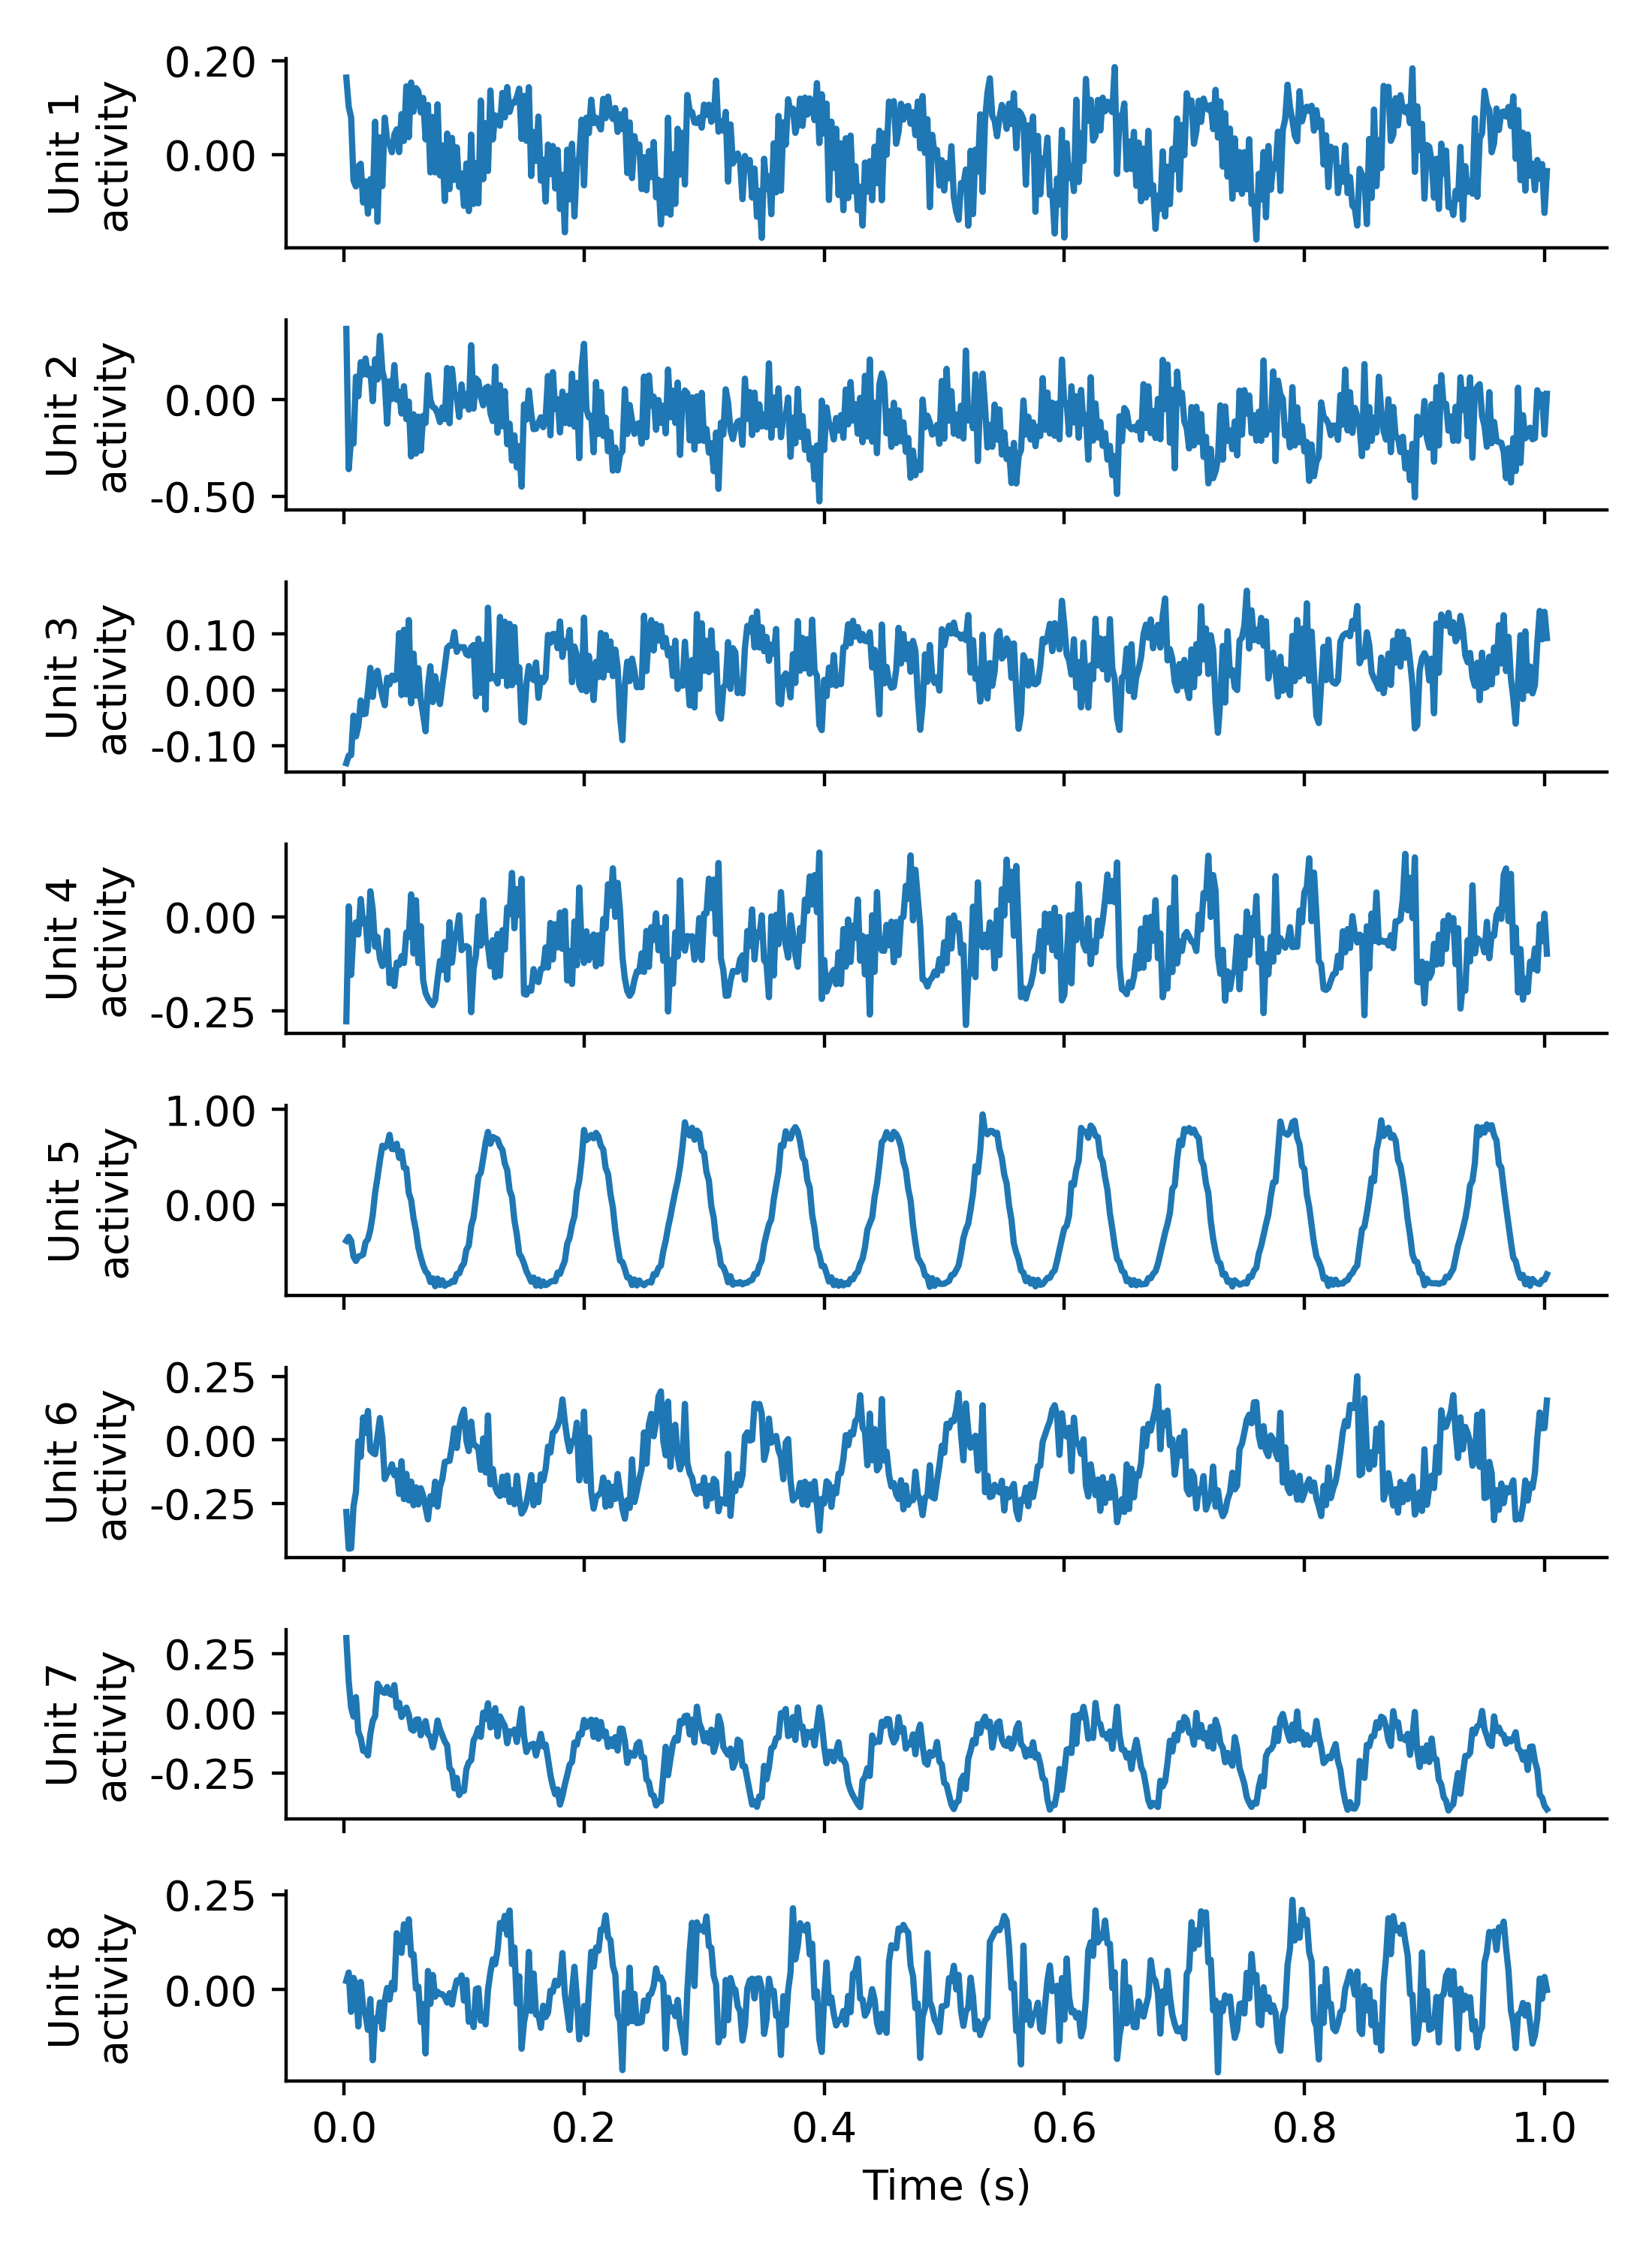

In [14]:
def _vis_internal_controller_signals(output_path: str) -> None:
    model_spec = mj.MjSpec.from_file("_inbox/flybody/floor.xml")  # type: ignore
    pl.remove_actuators(model_spec, "antenna*|wing*|rostrum*|haustellum*|*labrum*")
    pl.add_actuator_filtering(model_spec)

    model = model_spec.compile()
    act_ind = pl.get_walking_actuator_indices(model)
    sensor_suite = pl.SensorSuite(model)

    sim_state = mj.MjData(model)  # type: ignore
    ort_session = ort.InferenceSession("_inbox/controller.onnx")

    timestamps = list[float]()
    captured_values = list[np.ndarray]()

    while sim_state.time < 1.0:
        for _ in range(20):
            mj.mj_step(model, sim_state)  # type: ignore
            sensor_suite.update_state(sim_state)

        sensor_readings = sensor_suite.read()
        target_traj = pl.encode_trajectory(lambda t: (2.0 * t, 0.0, 0.0))
        controller_input = [pl.pack_controller_inputs(sensor_readings, target_traj)]
        b2o, csm = ort_session.run(
            ["block2/output", "control_signal_means"],
            {"input": controller_input},
        )

        timestamps.append(sim_state.time)
        captured_values.append(b2o[0])  # type: ignore

        sim_state.ctrl[act_ind] = pl.to_control_range(model, act_ind, csm[0])  # type: ignore

    n_subplots = 8

    plt.figure(figsize=(5.5, 7.5), dpi=400.0)
    for i in range(n_subplots):
        plt.subplot(n_subplots, 1, i + 1)
        plt.plot(timestamps, np.array(captured_values)[:, i])
        plt.gca().spines[["top", "right"]].set_visible(False)
        plt.gca().axes.yaxis.set_major_formatter(lambda n, _: f"{n: 0.2f}")  # type: ignore
        if i == n_subplots - 1:
            plt.xlabel("Time (s)")
        else:
            plt.gca().axes.xaxis.set_ticklabels([])  # type: ignore
        plt.ylabel(f"Unit {i + 1}\nactivity")
    plt.tight_layout()

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    plt.savefig(output_path)
    plt.close()

_vis_internal_controller_signals("_outbox/vis-10.png")
IPython.display.Image("_outbox/vis-10.png", width=640)

## Next steps

Now that you have some experience working with the fruit fly body model, we recommend taking a look at the project ideas in the readme file to see if any of them sound interesting to you, and maybe taking some time to brainstorm project ideas of your own. You can also read more about the body model in the [journal paper](https://doi.org/10.1038/s41586-025-09029-4), or practice using it by either modifying a few of the code cells in this tutorial, or deleting code cells and trying to recreate them.